# Latest experiment

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Housing Data

In [ ]:
class PlantsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train = True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.housing_data = pd.read_csv(csv_file)
        self.housing_data = self.housing_data.sample(frac=1)
        self.x = self.housing_data.drop('Class', axis = 1)
        self.y = self.housing_data[['Class']]
        self.y = self.y - 1
        
        length = len(self.y)
        print(length)
        train_len = int(length*0.8)
        
        if train:
          self.x = self.x.iloc[:train_len, :]
          self.y = self.y.iloc[:train_len, :]

        else:
          self.x = self.x.iloc[train_len:, :]
          self.y = self.y.iloc[train_len:, :]  

        self.x = torch.Tensor(self.x.values).to(device)
        self.y = torch.Tensor(self.y.values).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        features = self.x[idx]
        price = self.y[idx]
        return {'features': features, 'price': price}

In [ ]:
train_dataset = PlantsDataset(csv_file='plants.csv',
                                    root_dir='/', train = True)

test_dataset = PlantsDataset(csv_file='plants.csv',
                                    root_dir='/', train = False)

train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

1599
1599


In [ ]:
len(test_dataset)

320

In [ ]:
def test(net, test_loader, loss):
  running_loss = 0.0
  equal = 0
  total = 0
  for i, data in enumerate(test_loader, 0):
      inputs, labels = data['features'].to(device), data['price'].to(device)
      labels = labels.squeeze()
      labels = labels.long()
      outputs = net(inputs)
      preds = outputs.argmax(1)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

      equal += torch.eq(labels, preds).sum()
      total += len(labels)

  running_loss/=320
  accuracy = equal * 100 / total
  accuracy = accuracy.cpu().numpy()
  print("Avg Loss during Testing - ", running_loss)
  print("Test Accuracy - ", accuracy)
  return running_loss, accuracy

In [ ]:
def train(net, train_loader, num_epoch, optimizer, criterion, running_loss_batch = 200):
  for epoch in range(num_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data['features'].to(device), data['price'].to(device)
          labels = labels.squeeze()
          labels = labels.long()
          # zero the parameter gradients
          optimizer.zero_grad()
          # print(inputs)
          # forward + backward + optimize
          outputs = net(inputs)
          # print(outputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if i % running_loss_batch == (running_loss_batch-1):    # print every 150 mini-batches
              print('[%d, %5d] loss: %.6f' %
                    (epoch + 1, i + 1, running_loss / running_loss_batch))
              running_loss = 0.0

  print('Finished Training')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 100)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.14447331428527832
Test Accuracy -  1.25


0.14447331428527832

In [ ]:
for _ in range(5):
  train(net, train_loader, 100, optimizer, criterion, 50)
  test(net, test_loader, criterion)

Finished Training
Avg Loss during Testing -  0.04480822645127773
Test Accuracy -  tensor(61.2500, device='cuda:0')
Finished Training
Avg Loss during Testing -  0.028824968822300436
Test Accuracy -  tensor(76.2500, device='cuda:0')
Finished Training
Avg Loss during Testing -  0.021220549941062927
Test Accuracy -  tensor(83.7500, device='cuda:0')
Finished Training
Avg Loss during Testing -  0.016541658621281385
Test Accuracy -  tensor(87.8125, device='cuda:0')
Finished Training
Avg Loss during Testing -  0.013987440336495637
Test Accuracy -  tensor(91.8750, device='cuda:0')


In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.013987441221252084
Test Accuracy -  tensor(91.8750, device='cuda:0')


0.013987441221252084

### 3 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
          )
      )
  )

# def print_sparsity(net):
#   for name, param in net.named_parameters():
#     if 'weight' in name:
#       print(
#               "Sparsity in {}: {:.2f}%".format(name, 
#                   100. * float(torch.sum(param.data == 0))
#                   / float(param.data.nelement())
#               )
#           )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 100)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.14447331428527832
Test Accuracy -  tensor(1.2500, device='cuda:0')


0.14447331428527832

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

batch_loss = 25
epoch = 150

results_base_l1 = []
results_finetune_l1 = []

results_base_l1_acc = []
results_finetune_l1_acc = []

results_base_l2 = []
results_finetune_l2 = []

results_base_l2_acc = []
results_finetune_l2_acc = []


# Network
net = Net().to(device)
print_sparsity(net)

criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse, acc = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

results_base_l1_acc.append(acc)
results_finetune_l1_acc.append(acc)
results_base_l2_acc.append(acc)
results_finetune_l2_acc.append(acc)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
      (net.fc1, 'weight'),
      (net.fc2, 'weight'),
      (net.fc3, 'weight'),
    )
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss, base_acc = test(net, test_loader, criterion)

    train(net, train_loader, epoch, optimizer, criterion, batch_loss)
    finetune_loss, fine_acc = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      results_base_l1_acc.append(base_acc)
      results_finetune_l1_acc.append(fine_acc)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      results_base_l2_acc.append(base_acc)
      results_finetune_l2_acc.append(fine_acc)
      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Global sparsity: 0.00%
[1,    25] loss: 4.617849
[2,    25] loss: 4.604599
[3,    25] loss: 4.593285
[4,    25] loss: 4.572779
[5,    25] loss: 4.517997
[6,    25] loss: 4.396888
[7,    25] loss: 4.245118
[8,    25] loss: 4.123367
[9,    25] loss: 3.981923
[10,    25] loss: 3.906324
[11,    25] loss: 3.806250
[12,    25] loss: 3.734241
[13,    25] loss: 3.665391
[14,    25] loss: 3.606824
[15,    25] loss: 3.540056
[16,    25] loss: 3.475074
[17,    25] loss: 3.407463
[18,    25] loss: 3.319760
[19,    25] loss: 3.285664
[20,    25] loss: 3.227842
[21,    25] loss: 3.195293
[22,    25] loss: 3.118127
[23,    25] loss: 3.045318
[24,    25] loss: 2.990921
[25,    25] loss: 2.939512
[26,    25] loss: 2.910761
[27,    25] loss: 2.865515
[28,    25] loss: 2.801127
[29,    25] loss: 2.752358
[30,    25] loss: 2.696606
[31,    25] loss: 2.699037
[32,    25] loss: 2.675367
[33,    25] loss: 2.589303
[34, 

In [ ]:
results_base_l1

[0.0368280079215765,
 0.03824604116380215,
 0.046889663115143775,
 0.07239627912640571,
 0.11953216195106506,
 0.14299183040857316]

In [ ]:
results_finetune_l1

[0.0368280079215765,
 0.03439737726002932,
 0.029042783565819262,
 0.03849522266536951,
 0.0538621798157692,
 0.09886588528752327]

In [ ]:
results_base_l2

[0.0368280079215765,
 0.06372473575174809,
 0.09863003119826316,
 0.12740116715431213,
 0.13979460597038268,
 0.14633402675390245]

In [ ]:
results_finetune_l2

[0.0368280079215765,
 0.04004273284226656,
 0.05285604279488325,
 0.0464575856924057,
 0.044045723602175714,
 0.09139208942651748]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

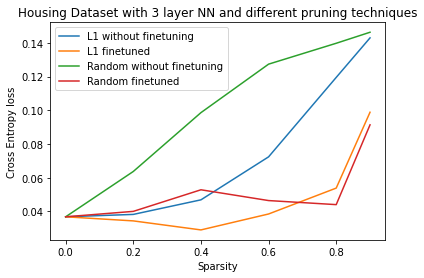

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 3 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('Cross Entropy loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

### 5 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Sparsity in fc4.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc4.weight == 0))
          / float(net.fc4.weight.nelement())
      )
  )
  print(
      "Sparsity in fc5.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc5.weight == 0))
          / float(net.fc5.weight.nelement())
      )
  )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
              + torch.sum(net.fc4.weight == 0)
              + torch.sum(net.fc5.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
              + net.fc4.weight.nelement()
              + net.fc5.weight.nelement()
          )
      )
  )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 100)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.14157524704933167
Test Accuracy -  1.875


(0.14157524704933167, array(1.875, dtype=float32))

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train(net, train_loader, 250, optimizer, criterion, 25)

[1,    25] loss: 4.619119
[2,    25] loss: 4.280630
[3,    25] loss: 3.985687
[4,    25] loss: 3.722831
[5,    25] loss: 3.492791
[6,    25] loss: 3.416917
[7,    25] loss: 3.291355
[8,    25] loss: 3.244715
[9,    25] loss: 3.140762
[10,    25] loss: 3.084871
[11,    25] loss: 2.974913
[12,    25] loss: 2.882841
[13,    25] loss: 2.840765
[14,    25] loss: 2.769365
[15,    25] loss: 2.721797
[16,    25] loss: 2.627972
[17,    25] loss: 2.599522
[18,    25] loss: 2.562167
[19,    25] loss: 2.532221
[20,    25] loss: 2.540459
[21,    25] loss: 2.461726
[22,    25] loss: 2.462004
[23,    25] loss: 2.389047
[24,    25] loss: 2.360477
[25,    25] loss: 2.333812
[26,    25] loss: 2.285867
[27,    25] loss: 2.267117
[28,    25] loss: 2.228044
[29,    25] loss: 2.221278
[30,    25] loss: 2.108635
[31,    25] loss: 2.133812
[32,    25] loss: 2.060961
[33,    25] loss: 2.039736
[34,    25] loss: 2.034802
[35,    25] loss: 2.024740
[36,    25] loss: 1.926041
[37,    25] loss: 1.931806
[38,    25

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.030147206410765647
Test Accuracy -  78.125


(0.030147206410765647, array(78.125, dtype=float32))

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
)

batch_loss = 25
epoch = 200

results_base_l1 = []
results_finetune_l1 = []

results_base_l2 = []
results_finetune_l2 = []

# Network
net = Net().to(device)
print_sparsity(net)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train(net, train_loader, epoch, optimizer, criterion, batch_loss)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse, _ = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    )

    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss, _ = test(net, test_loader, criterion)

    train(net, train_loader, int(epoch * (1-prune_value)), optimizer, criterion, batch_loss)
    finetune_loss, _ = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Sparsity in fc4.weight: 0.00%
Sparsity in fc5.weight: 0.00%
Global sparsity: 0.00%
[1,    25] loss: 4.632544
[2,    25] loss: 4.258997
[3,    25] loss: 3.775475
[4,    25] loss: 3.408725
[5,    25] loss: 3.269175
[6,    25] loss: 3.105145
[7,    25] loss: 3.048202
[8,    25] loss: 2.969313
[9,    25] loss: 2.920715
[10,    25] loss: 2.835890
[11,    25] loss: 2.800755
[12,    25] loss: 2.774574
[13,    25] loss: 2.772318
[14,    25] loss: 2.706975
[15,    25] loss: 2.681251
[16,    25] loss: 2.637559
[17,    25] loss: 2.666759
[18,    25] loss: 2.624788
[19,    25] loss: 2.585574
[20,    25] loss: 2.578463
[21,    25] loss: 2.565245
[22,    25] loss: 2.488984
[23,    25] loss: 2.550325
[24,    25] loss: 2.466408
[25,    25] loss: 2.488472
[26,    25] loss: 2.463687
[27,    25] loss: 2.397088
[28,    25] loss: 2.394201
[29,    25] loss: 2.369960
[30,    25] loss: 2.340850
[31,    25] loss: 2.270438

In [ ]:
results_base_l1

[0.039064118452370164,
 0.06395818032324314,
 0.1790763571858406,
 0.29676737189292907,
 0.4044028490781784,
 0.29185267984867097]

In [ ]:
results_finetune_l1

[0.039064118452370164,
 0.12012229412794113,
 0.07874030135571956,
 0.04445531293749809,
 0.13602148592472077,
 0.14465386867523194]

In [ ]:
results_base_l2

[0.039064118452370164,
 0.32684038281440736,
 0.3727020531892776,
 0.34391200840473174,
 0.2707553431391716,
 0.26085077226161957]

In [ ]:
results_finetune_l2

[0.039064118452370164,
 0.12333316281437874,
 0.14181091859936715,
 0.09698345437645912,
 0.11285362020134926,
 0.1309281289577484]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

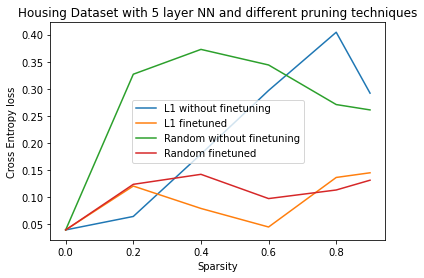

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 5 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('Cross Entropy loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

### 10 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Sparsity in fc4.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc4.weight == 0))
          / float(net.fc4.weight.nelement())
      )
  )
  print(
      "Sparsity in fc5.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc5.weight == 0))
          / float(net.fc5.weight.nelement())
      )
  )

  print(
      "Sparsity in fc6.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc6.weight == 0))
          / float(net.fc6.weight.nelement())
      )
  )
  print(
      "Sparsity in fc7.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc7.weight == 0))
          / float(net.fc7.weight.nelement())
      )
  )
  print(
      "Sparsity in fc8.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc8.weight == 0))
          / float(net.fc8.weight.nelement())
      )
  )
  print(
      "Sparsity in fc9.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc9.weight == 0))
          / float(net.fc9.weight.nelement())
      )
  )
  print(
      "Sparsity in fc10.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc10.weight == 0))
          / float(net.fc10.weight.nelement())
      )
  )

  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
              + torch.sum(net.fc4.weight == 0)
              + torch.sum(net.fc5.weight == 0)
              + torch.sum(net.fc6.weight == 0)
              + torch.sum(net.fc7.weight == 0)
              + torch.sum(net.fc8.weight == 0)
              + torch.sum(net.fc9.weight == 0)
              + torch.sum(net.fc10.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
              + net.fc4.weight.nelement()
              + net.fc5.weight.nelement()
              + net.fc6.weight.nelement()
              + net.fc7.weight.nelement()
              + net.fc8.weight.nelement()
              + net.fc9.weight.nelement()
              + net.fc10.weight.nelement()
          )
      )
  )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 8)
        self.fc8 = nn.Linear(8, 4)
        self.fc9 = nn.Linear(4, 4)
        self.fc10 = nn.Linear(4, 100)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x)) 
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = self.fc10(x)
        return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# # optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  0.14640987068414688
Test Accuracy -  2.5


(0.14640987068414688, array(2.5, dtype=float32))

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    (net.fc6, 'weight'),
    (net.fc7, 'weight'),
    (net.fc8, 'weight'),
    (net.fc9, 'weight'),
    (net.fc10, 'weight'),
    )

batch_loss = 27
epoch = 50

results_base_l1 = []
results_finetune_l1 = []

results_base_l2 = []
results_finetune_l2 = []

# Network
net = Net().to(device)
print_sparsity(net)

# criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse, _ = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    (net.fc6, 'weight'),
    (net.fc7, 'weight'),
    (net.fc8, 'weight'),
    (net.fc9, 'weight'),
    (net.fc10, 'weight'),
    )
    
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss, _ = test(net, test_loader, criterion)

    train(net, train_loader, epoch, optimizer, criterion, batch_loss)
    finetune_loss, _ = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Sparsity in fc4.weight: 0.00%
Sparsity in fc5.weight: 0.00%
Global sparsity: 0.00%
[1,    27] loss: 4.646023
[2,    27] loss: 4.636933
[3,    27] loss: 4.624580
[4,    27] loss: 4.556397
[5,    27] loss: 4.500441
[6,    27] loss: 4.468856
[7,    27] loss: 4.449550
[8,    27] loss: 4.391895
[9,    27] loss: 4.364040
[10,    27] loss: 4.346049
[11,    27] loss: 4.327953
[12,    27] loss: 4.312538
[13,    27] loss: 4.290895
[14,    27] loss: 4.279556
[15,    27] loss: 4.253607
[16,    27] loss: 4.248405
[17,    27] loss: 4.233179
[18,    27] loss: 4.204756
[19,    27] loss: 4.198934
[20,    27] loss: 4.177586
[21,    27] loss: 4.190125
[22,    27] loss: 4.155558
[23,    27] loss: 4.157257
[24,    27] loss: 4.141148
[25,    27] loss: 4.132850
[26,    27] loss: 4.116157
[27,    27] loss: 4.111962
[28,    27] loss: 4.106843
[29,    27] loss: 4.096178
[30,    27] loss: 4.085420
[31,    27] loss: 4.069962

In [ ]:
results_base_l1

[0.12222350165247917,
 0.12220958024263381,
 0.12239801809191704,
 0.12350205928087235,
 0.14508503079414367,
 0.1502710148692131]

In [ ]:
results_finetune_l1

[0.12222350165247917,
 0.14660850614309312,
 0.14563148617744445,
 0.14613125324249268,
 0.14722002297639847,
 0.1473870635032654]

In [ ]:
results_base_l2

[0.12222350165247917,
 0.13278350979089737,
 0.1425493150949478,
 0.14497094452381135,
 0.14513591527938843,
 0.14485737681388855]

In [ ]:
results_finetune_l2

[0.12222350165247917,
 0.14689913690090178,
 0.1449314534664154,
 0.14417732805013656,
 0.1438053220510483,
 0.14461893141269683]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

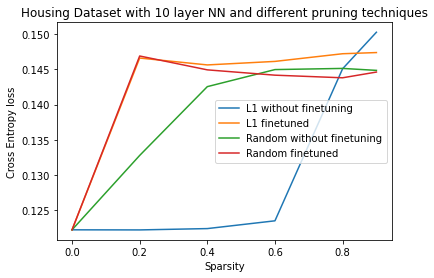

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 10 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('Cross Entropy loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

# Archive

In [ ]:
net.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (fc6): Linear(in_features=8, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=8, bias=True)
  (fc8): Linear(in_features=8, out_features=4, bias=True)
  (fc9): Linear(in_features=4, out_features=4, bias=True)
  (fc10): Linear(in_features=4, out_features=100, bias=True)
)>

In [ ]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            + torch.sum(net.fc1.weight == 0)
            + torch.sum(net.fc2.weight == 0)
            + torch.sum(net.fc3.weight == 0)
        )
        / float(
            + net.fc1.weight.nelement()
            + net.fc2.weight.nelement()
            + net.fc3.weight.nelement()
        )
    )
)

Sparsity in fc1.weight: 91.41%
Sparsity in fc2.weight: 93.36%
Sparsity in fc3.weight: 91.99%
Global sparsity: 92.05%


In [ ]:
# Testing after pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

RuntimeError: ignored

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Testing after finte-tuning with pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

## Plants classification

# Experiment 1


**Dataset - One hundred plants texture**

**Architecture - 3 layer Neural Network**

### Preliminary training

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda:0")
device

In [ ]:
class HouseSalesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train = True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.housing_data = pd.read_csv(csv_file)
        self.x = self.housing_data.drop('price', axis = 1)
        df = self.housing_data.drop('date', axis = 1)
        self.x = (df-df.mean())/df.std()
        self.y = self.housing_data[['price']]/1000

        if train:
          self.x = self.x.iloc[:18000, :]
          self.y = self.y.iloc[:18000, :]

        else:
          self.x = self.x.iloc[18000:, :]
          self.y = self.y.iloc[18000:, :]  


        print('Length = ', len(self.y))
        self.x = torch.Tensor(self.x.values).to(device)
        self.y = torch.Tensor(self.y.values).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if self.transform:
        #     sample = self.transform(sample)

        features = self.x[idx]
        price = self.y[idx]
        return {'features': features, 'price': price}

In [ ]:
train_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = True)

test_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = False)

train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch, sample_batched['features'].size(),
#           sample_batched['price'].size())
#     outputs = net(sample_batched['features'])
#     print(outputs)
#     break

In [ ]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
# Testing before training

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Testing after training

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
# dataiter = iter(testloader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
# outputs = net(images)

### Global pruning

In [ ]:
net.parameters

In [ ]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            + torch.sum(net.fc1.weight == 0)
            + torch.sum(net.fc2.weight == 0)
            + torch.sum(net.fc3.weight == 0)
        )
        / float(
            + net.fc1.weight.nelement()
            + net.fc2.weight.nelement()
            + net.fc3.weight.nelement()
        )
    )
)

In [ ]:
# Testing after pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Testing after finte-tuning with pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
module = net.fc1
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
prune.random_unstructured(module, name="weight", amount=0.15)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
print(module._forward_pre_hooks)

In [ ]:
# prune.l1_unstructured(module, name="bias", amount=0.2)

In [ ]:
# print(list(module.named_parameters()))

In [ ]:
# print(list(module.named_buffers()))

In [ ]:
# print(module.bias)

In [ ]:
# print(module._forward_pre_hooks)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'], data['price']

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

## From the blog

### Local pruning

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device=device)

In [ ]:
module = model.fc1
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
prune.random_unstructured(module, name="weight", amount=0.3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
print(module._forward_pre_hooks)

In [ ]:
prune.l1_unstructured(module, name="bias", amount=3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.bias)

In [ ]:
print(module._forward_pre_hooks)

### Global pruning

In [ ]:
model = LeNet()

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv1.weight == 0))
        / float(model.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv2.weight == 0))
        / float(model.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc1.weight == 0))
        / float(model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc2.weight == 0))
        / float(model.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc3.weight == 0))
        / float(model.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.conv1.weight == 0)
            + torch.sum(model.conv2.weight == 0)
            + torch.sum(model.fc1.weight == 0)
            + torch.sum(model.fc2.weight == 0)
            + torch.sum(model.fc3.weight == 0)
        )
        / float(
            model.conv1.weight.nelement()
            + model.conv2.weight.nelement()
            + model.fc1.weight.nelement()
            + model.fc2.weight.nelement()
            + model.fc3.weight.nelement()
        )
    )
)

### Custom pruning

In [ ]:
class FooBarPruningMethod(prune.BasePruningMethod):
    """Prune every other entry in a tensor
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        mask.view(-1)[::2] = 0
        return mask

In [ ]:
def foobar_unstructured(module, name):
    """Prunes tensor corresponding to parameter called `name` in `module`
    by removing every other entry in the tensors.
    Modifies module in place (and also return the modified module)
    by:
    1) adding a named buffer called `name+'_mask'` corresponding to the
    binary mask applied to the parameter `name` by the pruning method.
    The parameter `name` is replaced by its pruned version, while the
    original (unpruned) parameter is stored in a new parameter named
    `name+'_orig'`.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (string): parameter name within `module` on which pruning
                will act.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input
            module

    Examples:
        >>> m = nn.Linear(3, 4)
        >>> foobar_unstructured(m, name='bias')
    """
    FooBarPruningMethod.apply(module, name)
    return module

In [ ]:
model = LeNet()
foobar_unstructured(model.fc3, name='bias')

print(model.fc3.bias_mask)